# Assignment 06: Ensembles of trees

In this assignment, we will try out the two ensemble methods mentioned in class; random forests and gradient boosted trees. We will use the two datasets in the previous homework; the synthetic, distance-based classification data and the Titanic dataset. 

Note that as opposed to the last homework, the modeling of the distance-based dataset is part of the assignment this time (as opposed to being a pre-solved tutorial). So please make sure that you do the work for both datasets.

## Learning from the distance-based synthetic data

### Create the synthetic dataset

We begin by copying the data-generation code from the previous homework. Make sure to execute all the code cells below needed to create and visualize the data.

As in the previous homework, the datasets will be created by sampling points inside a square using a uniform distribution, and labeling them according to their distance from the origin; points closer than a distance of 1 will be called 'near', and others will be called 'far'. To make the setting a bit closer to "real life", we add some noise to the data by switching the labels of some of the points randomly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('Paired'))

%matplotlib inline

In [2]:
# Define functions for data creation and visualization

def create_data(n_points, p_flip=0.1):
    """Returns a dataframe with columns X1, X2, y. First creates an 
    (n_grid x n_grid) square inside 0 < X1, X2 < 2, and then labels the 
    points on this grid as 'near' if they are a distance of < 1 from the 
    origin, 'far' otherwise. Finally, randomly flips the labels with a
    probability of p_flip. The labels are contained in column y."""

    # Sample from the interval [0,2] using the uniform distribution
    X1 = np.random.rand(n_points) * 2
    X2 = np.random.rand(n_points) * 2
    X = np.column_stack([X1,X2])

    # The output variable measures whether the distance is < 1
    y = np.sum(X*X,axis=1) < 1

    # The y entries to flip, randomly sampled
    flip = np.random.choice([True, False], size=len(y), p=[p_flip, 1-p_flip])
    y = np.logical_xor(y, flip)

    # Change the labeling from True/False to "near", "far"
    y = np.where(y, 'near', 'far')

    # Return data frame
    return pd.DataFrame({'X1': X1, 'X2': X2, 'y':y})

def plot_classes(df):
    """Visualizes the two-class data created by create_data()"""
    groups = pd.groupby(df, 'y')

    for name, group in groups: 
        plt.plot(group.X1, group.X2, '.', label=name)
    
    # have equal scaling for x and y
    plt.axis('equal') 
    # put the color legend outside the plot region
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16) 
    plt.show()

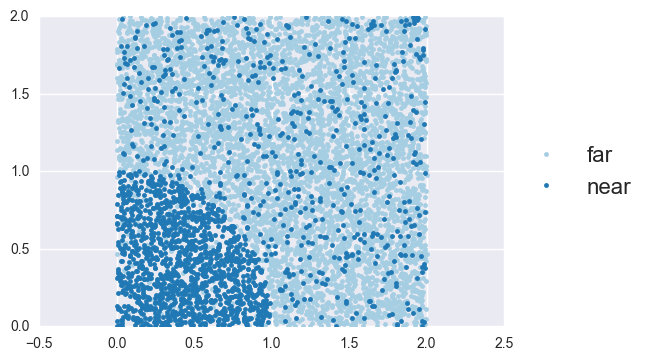

In [3]:
# Create and visualize a dataset

RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)

df_data = create_data(7500, p_flip=0.1)
plot_classes(df_data)

Let's begin by splitting the dataset into training and test sets and importing the relevant classifiers. Since we got some experience with "manual" sampling last time, this time I'm directly using the `sample()` method of Pandas (and after sampling a holdout set, we are dropping its elements from the full set to create the training set).

In [4]:
df_holdout = df_data.sample(frac = 0.20, random_state = RANDOM_SEED)
df_train = df_data.drop(df_holdout.index)

print "Number of training points: ", len(df_train)
print "Number of holdout points: ", len(df_holdout)

Number of training points:  6000
Number of holdout points:  1500


Recall the basic workflow in `scikit learn`:

1. Create an instance of a machine learning method (e.g. a decision tree classifier, random forest classifier, gradient boosted classifier), setting the parameters to desired values
2. Use the `.fit()` method of the resulting classifier object on a dataset to learn from the data
3. Use the `.predict()` method of the resulting classifier to make predictions on new data.

This time we will use this workflow for the ensemble models.

In [5]:
# Import the random forest and gradient boosting classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Build a random forest classifier

- Create a variable named `rf_simple` that holds a random forest classifier with the following initialization parameters: 
  - `n_estimators=100` (this makes a forest consisting of 100 trees)
  - `max_features=2` (this makes each node in the tree consider 2 features as split candidates--since this synthetic problem is two-dimensional, this means we will consider both features as candidates)
- Leave all the other parameters at their default values (you can find the full list of parameters on [this documentation page](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

Note that we are __not__ restricting the `max_leaf_nodes` parameter. This was the parameter we tuned over while working with classification trees in the previous assignment. One _could_ explicitly choose this parameter in random forests, as well, but it turns out that in this case it is usually better to build very deep trees, and reduce the effect of overfitting by combining a large number of trees, each trained on a different sample. When each tree is overfit to a different sample, the combined predictions from the forest can still be accurate. (Leaving `max_leaf_nodes` unspecified removes the restriction on this pararameter, and trees can get arbitrarily deep)

Note also that each tree in the forest is built on a random sample from the same dataset. Typically, the samples are drawn **with replacement**, with the sample size being equal to the size of the original dataset. Because of this sampling, there is some randomness involved in the building of a random forest. You can specify random states/seeds to the random forest classifier if you want the model to be reproducible.

In [6]:
rf_simple = RandomForestClassifier(n_estimators=100,max_features=2)

- Next, use the `.fit()` method of this object, `rf_simple` on the training set to create a random forest model (as before, you have to specify the input columns and the output column as separate arguments, see the tutorial section of the previous homework for a reminder, or use scikit-learn online documentation).

In [8]:
rf_simple.fit(df_train[['X1', 'X2']], df_train['y'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

- Now using the `.predict()` method of this random forest to create two variables, `rf_simple_train_preds` and`rf_simple_holdout_preds`, which hold the predictions on the training set and the holdout set, respectively.

In [10]:
rf_simple_train_preds = rf_simple.predict(df_train[['X1','X2']])
rf_simple_holdout_preds = rf_simple.predict(df_holdout[['X1','X2']])

- Next, evaluate these two sets of predictions: print the fraction of correct predictions on the training set and the holdout set.

In [12]:
print "Accuracy on the training set:", np.mean(df_train.y == rf_simple_train_preds)
print "Accuracy on the holdout set:", np.mean(df_holdout.y == rf_simple_holdout_preds)

 Accuracy on the training set: 1.0
Accuracy on the holdout set: 0.896666666667


Optional/bonus task: visualize the predictions. (**All the bullets in this cell are optional**)

- Create a copy of `df_train` named `df_train_preds`, and a copy of `df_holdout` named `df_holdout_preds` 
  - Note that you need to use the `.copy()` method of the data frame objects, you shouldn't simply use `df_train_preds = df_train`, etc. Read [this answer](http://stackoverflow.com/a/27680109/5182016) if you are not clear on why you need to do this.
- Replace the "`y`" columns of these two data frames with the predictions you computed above, i.e., `rf_simple_train_preds` and `rf_simple_holdout_preds`.
- Using the `plot_classes()` function defined above, visualize the two sets of predictions, and compare with the plots for the correct values.

In [124]:
df_train_preds = df_train.copy()
df_holdout_preds = df_holdout.copy()

In [125]:
df_train_preds['y'] = rf_simple_train_preds
df_holdout_preds['y'] = rf_simple_holdout_preds

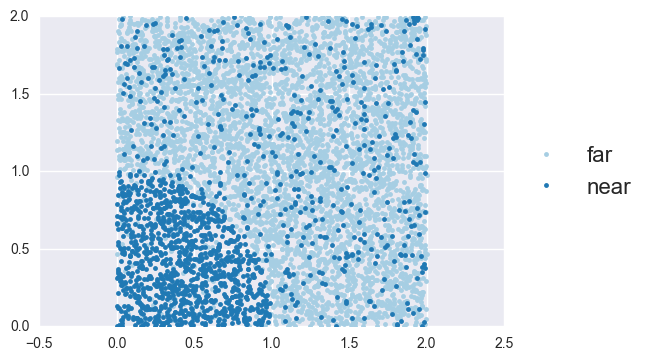

In [126]:
plot_classes(df_train_preds)

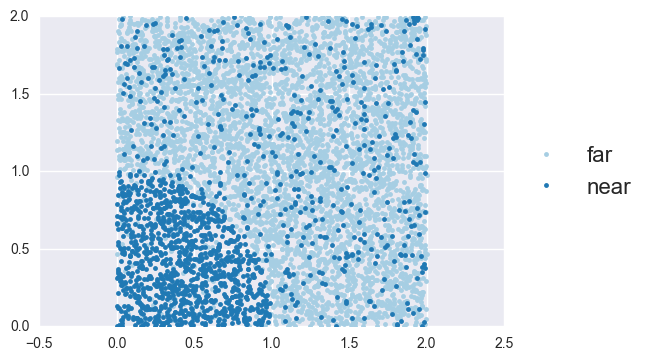

In [128]:
plot_classes(df_train)

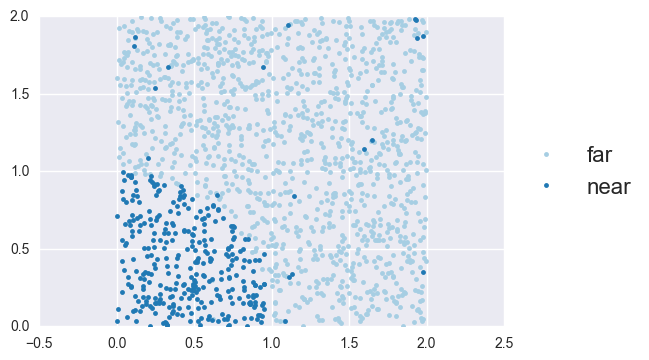

In [127]:
plot_classes(df_holdout_preds)

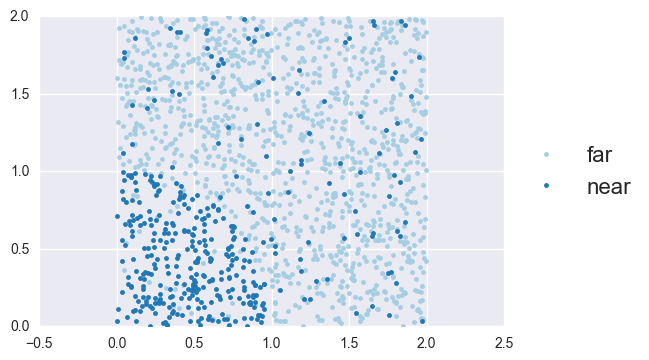

In [129]:
plot_classes(df_holdout)

### Build a gradient boosted classifier

Next, we do a similar thing with gradient boosted classifiers; we create a simple GB model.

- Create a variable named `gb_simple` that holds a gradient boosted classifier with the following initialization parameters: 
  - `n_estimators=100` (this makes a forest consisting of 100 trees)
  - `learning_rate=0.1` (recall the learning rate parameter discussed in class)
  - `max_leaf_nodes=3` 
- Leave all the other parameters at their default values (you can find the full list of parameters on [this documentation page](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html))

Note that as opposed to the case of random forests (and similar to the case of a single decision tree), we __are__ restricting the `max_leaf_nodes` parameter. This is commonly done with gradient boosted models.

In [13]:
gb_simple = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_leaf_nodes=3)

- Next, use the `.fit()` method of this object, `gb_simple` on the training set to create a gradient boosted tree model (as before, you have to specify the input columns and the output column as separate arguments, see the tutorial section of the previous homework for a reminder, or use scikit-learn examples online).

In [14]:
gb_simple.fit(df_train[['X1', 'X2']], df_train['y'])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=3,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

- Now using the `.predict()` method of this gradient boosted model to create two variables, `gb_simple_train_preds` and `gb_simple_holdout_preds`, which hold the predictions on the training set and the holdout set, respectively.

In [15]:
gb_simple_train_preds = gb_simple.predict(df_train[['X1','X2']])
gb_simple_holdout_preds = gb_simple.predict(df_holdout[['X1','X2']])

- Next, evaluate these two sets of predictions: print the fraction of correct predictions on the training set and the holdout set.

In [16]:
print "Accuracy on the training set:", np.mean(df_train.y == gb_simple_train_preds)
print "Accuracy on the holdout set:", np.mean(df_holdout.y == gb_simple_holdout_preds)

Accuracy on the training set: 0.8955
Accuracy on the holdout set: 0.897333333333


Optional/bonus: visualize the predictions. (**All the bullets in this cell are optional**)

- Create a copy of `df_train` named `df_train_preds`, and a copy of `df_holdout` named `df_holdout_preds` (you need to use the `.copy()` method of the data frame objects, you shouldn't simply use `df_train_preds = df_train`, etc. Read [this answer](http://stackoverflow.com/a/27680109/5182016) if you are not clear on why you need to do this.
- Replace the "`y`" columns of these two data frames with the predictions you computed above, i.e., `gb_simple_train_preds` and `gb_simple_holdout_preds`.
- Using the `plot_classes()` function defined above, visualize the two sets of predictions, and compare with the plots for the correct values.

In [131]:
df_train_preds = df_train.copy()
df_holdout_preds = df_holdout.copy()
df_train_preds['y'] = gb_simple_train_preds
df_holdout_preds['y'] = gb_simple_holdout_preds

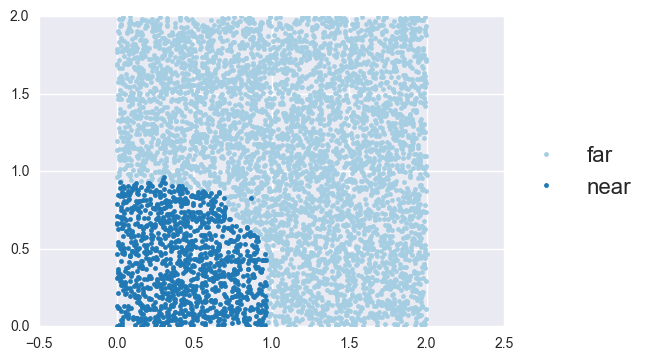

In [132]:
plot_classes(df_train_preds)

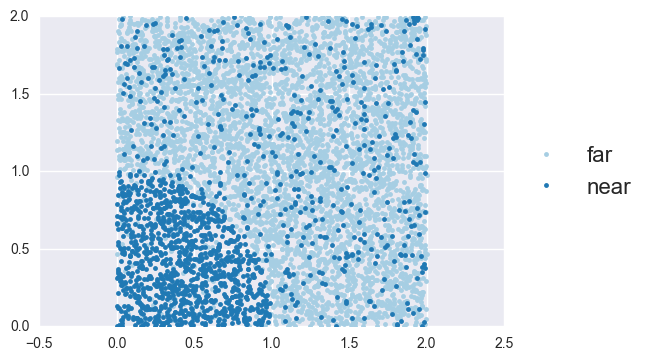

In [133]:
plot_classes(df_train)

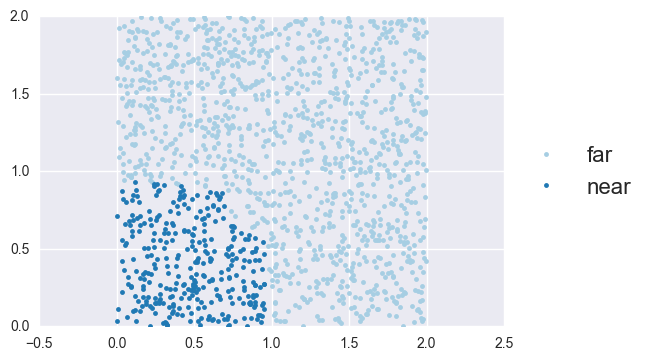

In [134]:
plot_classes(df_holdout_preds)

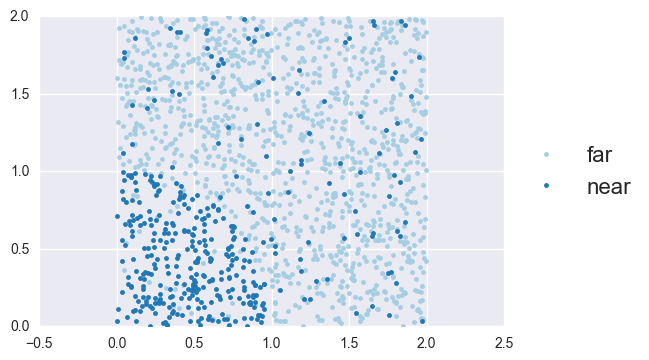

In [135]:
plot_classes(df_holdout)

### Tune a random forest model

Let us next tune a random forest model. For this, you can use the tuning section of the tutorial in the previous homework for help with the set up of the tuning loop, or you can write your own tuning routines. Note that we have already split our dataset into a training piece and a holdout piece, so we only need to loop over a series of values for the tuning parameters. 

For this section, we will only tune over the number of trees (i.e., the `n_estimators` parameters in scikit-learn).

- Write a loop that tries a series of values for for `n_estimators` (make sure that you try at least 25 different values for this parameter). For each value, train a random forest model on the training set, and record the accuracy of the model on both the training set and the holdout set. You can use two dictionaries, `train_accuracies` and `holdout_accuracies` to store these accuracies, the keys of the dictionaries being the `n_estimators` values tried, and the values of the dictionaries being the accuracy values observed.
- For this exercise, set the `max_features` parameter of the random forest classifier to 2 (as above), and leave all other parameters at their default values.

In [34]:
train_accuracies = {}
holdout_accuracies = {}

# The range of max_leaf_nodes to try
n_estimator_values = range(1,60,1)

# Loop over all values
for n_estimator in n_estimator_values:
    # Create a classifier with this given number of max_leaf_nodes
    rfm = RandomForestClassifier(n_estimators=n_estimator,max_features=2)
    # Fit the created classifier to the train_train data
    rfm.fit(df_train[['X1', 'X2']], df_train['y'])

    # Make predictions on the training set
    train_preds = rfm.predict(df_train[['X1','X2']])

    # Make predictions on the holdout set
    holdout_preds = rfm.predict(df_holdout[['X1','X2']])

    # Evaluate accuracy on each data set
    train_accuracy = np.mean(train_preds==df_train['y'])
    holdout_accuracy = np.mean(holdout_preds == df_holdout['y'])
    
    # Record the accuracies
    train_accuracies[n_estimator] = train_accuracy
    holdout_accuracies[n_estimator] = holdout_accuracy

- Plot the training and holdout accuracies as a function of the `n_estimators` parameter. What behavior do you see? What happens to the training accuracy as the number of trees increases? What happens to the holdout accuracy? Which dataset results in a higher accuracy, holdout or training?

In [35]:
tuning_accuracies_df = pd.DataFrame({'train':train_accuracies, 'holdout': holdout_accuracies})
tuning_accuracies_df.index.name = 'n_estimators'
tuning_accuracies_df.head()

,holdout,train
n_estimators,,
1,0.815333,0.934500
2,0.862000,0.940333
3,0.858667,0.968000
4,0.876000,0.958667
5,0.875333,0.972833


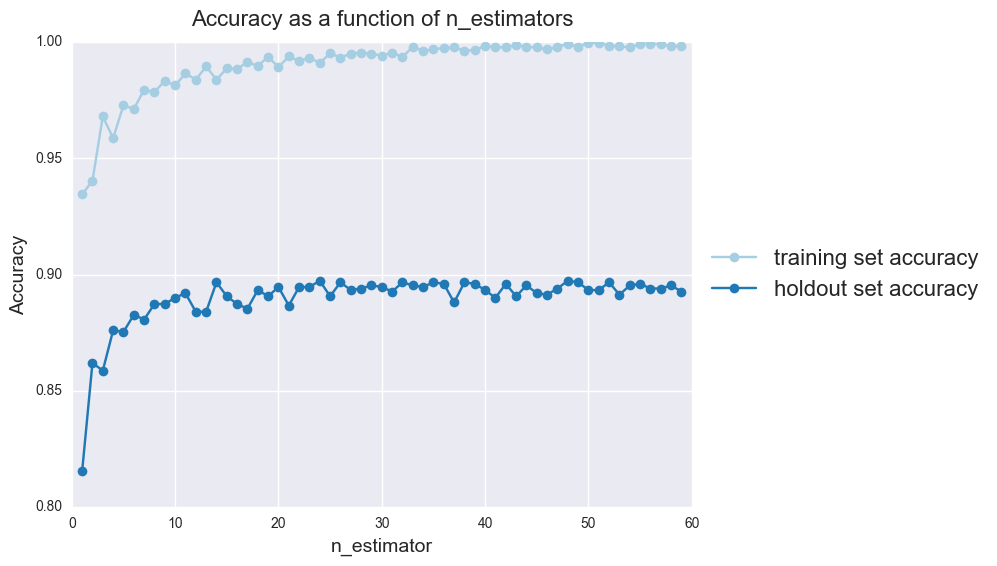

In [42]:
plt.figure(figsize=(8,6))
plt.title("Accuracy as a function of n_estimators", fontsize=16, y=1.02)
plt.plot(tuning_accuracies_df.train, 'o-', label='training set accuracy')
plt.plot(tuning_accuracies_df.holdout, 'o-', label='holdout set accuracy')
plt.xlabel('n_estimator', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.show()

The model starts the memorise the train set as the number of estimators increase. However accuracy doesnt increase and converge to a nearly constant accuracy asymptotically while training set converges to 1.

In [122]:
maxn = tuning_accuracies_df.holdout.argmax()
print 'value of n_estimator for Best Accuracy'
print maxn,'\t',tuning_accuracies_df.holdout[maxn]

value of n_estimator for Best Accuracy
33 	0.905333333333


### Tune a gradient boosted model

Let us next tune a gradient boosted tree model. Once again, you can use the tuning section of the tutorial in the previous assignment for help with the setup of the tuning loop, or you can write your own.

This time, we will tune over **two parameters** simulatenously, instead of a single parameter. 

- Write a nested (double) loop to
  - try 3 different values for the `max_leaf_nodes` parameter, and for each value of `max_leaf_nodes`
  - a series of values for the `n_estimators` parameter.
- Make sure that you try at least 25 different values for `n_estimators`. Fix the `learning_rate` parameter to 0.1, and leave all other parameters to their default values. 
- For each iteration (i.e. for each pair of values for `n_estimators` and `max_leaf_nodes`), record the training accuracy and the holdout accuracy.

In [3]:
c_vals = [0.1,0.2,0.4,0.8,1,2,4,8,16,32,64]

In [115]:
train_accuracies = {max_leaf_nodes_val:{} for max_leaf_nodes_val in max_leaf_nodes_values}
holdout_accuracies = {max_leaf_nodes_val:{} for max_leaf_nodes_val in max_leaf_nodes_values}

n_estimator_values = range(1,60,2)
for max_leaf_nodes in max_leaf_nodes_values:
    for n_estimator in n_estimator_values:
        # Create a classifier with this given number of max_leaf_nodes
        gbm = GradientBoostingClassifier(n_estimators=n_estimator,max_leaf_nodes=max_leaf_nodes,learning_rate=0.1)
        # Fit the created classifier to the train_train data
        gbm.fit(df_train[['X1', 'X2']], df_train['y'])

        # Make predictions on the training set
        train_preds = gbm.predict(df_train[['X1','X2']])

        # Make predictions on the holdout set
        holdout_preds = gbm.predict(df_holdout[['X1','X2']])

        # Evaluate accuracy on each data set
        train_accuracy = np.mean(train_preds==df_train['y'])
        holdout_accuracy = np.mean(holdout_preds == df_holdout['y'])
        
        # Record the accuracies
        train_accuracies[max_leaf_nodes][n_estimator] = train_accuracy
        holdout_accuracies[max_leaf_nodes][n_estimator] = holdout_accuracy

- Plot the training and holdout accuracies as a function of the `n_estimators` parameter
- In your plots, use two separate curves for each  each value of `max_leaf_nodes`; one holdout curve and one training curve. This makes a total of 6 curves representing accuracy as a function of `n_estimators`.

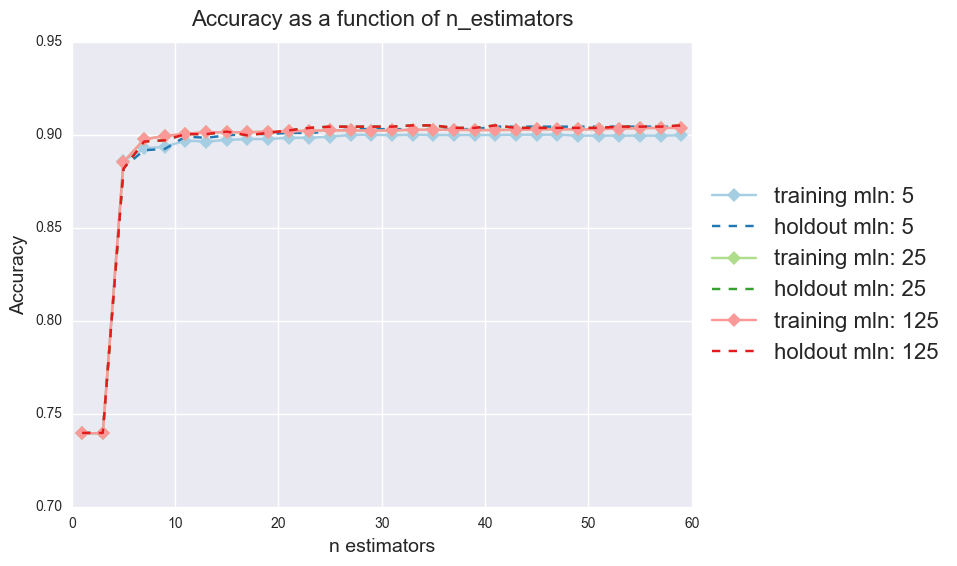

In [116]:
plt.figure(figsize=(8,6))
plt.title("Accuracy as a function of n_estimators", fontsize=16, y=1.02)

for max_leaf_nodes in max_leaf_nodes_values:
    tuning_accuracies_df = pd.DataFrame({'train':train_accuracies[max_leaf_nodes], 'holdout': holdout_accuracies[max_leaf_nodes]})
    tuning_accuracies_df.index.name = 'n_estimators'

    plt.plot(tuning_accuracies_df.train, 'D-', label= ''.join(  ['training mln: ', str(max_leaf_nodes)] ))
    plt.plot(tuning_accuracies_df.holdout, '--', label=''.join(  ['holdout mln: ', str(max_leaf_nodes)] ))
    
plt.xlabel('n estimators', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.show()

## Learning from the Titanic data

### Tuning an ensemble model on Titanic

For this assignment, I'm uploading a version of the Titanic dataset that is pre-processed as in the previous assignment; missing values are imputed, certain columns are dropped, and categorical columns are turned into numerical ones using the `get_dummies()` function of Pandas.

We will read this dataset, create a training/holdout split, and you will **tune one model of your choice** (a random forest or a gradient boosted model). You are free to choose the parameters you would like to tune over; you can use the parameters we tried above, or you can dive into scikit-learn's documentation to pick other parameters to tune over. 

- Execute the cells below to read the pre-processed Titanic set, and split it into a training set and a  holdout set.

In [93]:
titanic_pre_processed = pd.read_csv('titanic_train_pre_processed.csv')

RANDOM_SEED = 5
titanic_holdout = titanic_pre_processed.sample(frac=.3, random_state=RANDOM_SEED)
titanic_train = titanic_pre_processed.drop(titanic_holdout.index)

- Tune a random forest model or a gradient boosted tree model using the Titanic training/holdout datasets. You will do this by trying a set of values for the parameters you choose, and evaluating the holdout accuracy of each parameter combination tried, and identifying the parameter combination with the best accruacy.
- I want you to report the best parameter combination you find, but I'm not asking you to find the "absolute best model possible"; just try out some parameter values as in the examples above, and report the best one (in terms of holdout accruacy) you encounter.

In [94]:
gbm_t = GradientBoostingClassifier(max_leaf_nodes=30,n_estimators=30,learning_rate=0.1)
gbm_t.fit(titanic_train.drop('Survived',axis=1) , titanic_train['Survived'])

holdout_preds = gbm_t.predict(titanic_holdout.drop('Survived',axis=1))
train_preds = gbm_t.predict(titanic_train.drop('Survived',axis=1))

In [95]:
print 'titanic_holdout\t',np.mean(holdout_preds == titanic_holdout['Survived'])
print 'titanic_train\t',np.mean(train_preds == titanic_train['Survived'])

titanic_holdout	0.823970037453
titanic_train	0.88141025641


In [107]:
max_leaf_nodes_values = [5,25,125]

train_accuracies = {max_leaf_nodes_val:{} for max_leaf_nodes_val in max_leaf_nodes_values}
holdout_accuracies = {max_leaf_nodes_val:{} for max_leaf_nodes_val in max_leaf_nodes_values}

n_estimator_values = range(1,120,5)
for max_leaf_nodes in max_leaf_nodes_values:
    for n_estimator in n_estimator_values:
        # Create a classifier with this given number of max_leaf_nodes
        gbm_t = GradientBoostingClassifier(n_estimators=n_estimator,max_leaf_nodes=max_leaf_nodes,learning_rate=0.1)
        # Fit the created classifier to the train_train data
        gbm_t.fit(titanic_train.drop('Survived',axis=1) , titanic_train['Survived'])

        # Make predictions on the training set
        train_preds = gbm_t.predict(titanic_train.drop('Survived',axis=1))

        # Make predictions on the holdout set
        holdout_preds = gbm_t.predict(titanic_holdout.drop('Survived',axis=1))

        # Evaluate accuracy on each data set
        train_accuracy = np.mean(train_preds == titanic_train['Survived'])
        holdout_accuracy = np.mean(holdout_preds == titanic_holdout['Survived'])
        
        # Record the accuracies
        train_accuracies[max_leaf_nodes][n_estimator] = train_accuracy
        holdout_accuracies[max_leaf_nodes][n_estimator] = holdout_accuracy

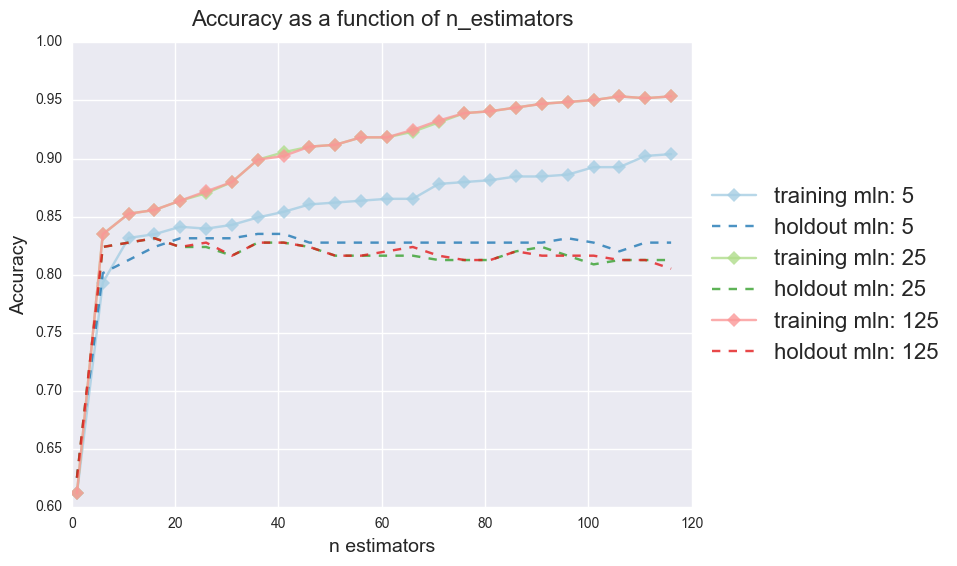

In [114]:
plt.figure(figsize=(8,6))
plt.title("Accuracy as a function of n_estimators", fontsize=16, y=1.02)

for max_leaf_nodes in max_leaf_nodes_values:
    tuning_accuracies_df = pd.DataFrame({'train':train_accuracies[max_leaf_nodes], 'holdout': holdout_accuracies[max_leaf_nodes]})
    tuning_accuracies_df.index.name = 'n_estimators'
    plt.plot(tuning_accuracies_df.train, 'D-', label= ''.join(  ['training mln: ', str(max_leaf_nodes)] ),alpha=0.8)
    plt.plot(tuning_accuracies_df.holdout, '--', label=''.join(  ['holdout mln: ', str(max_leaf_nodes)] ),alpha=0.8)
    
plt.xlabel('n estimators', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.show()

Values are very near to each other.

In [112]:
for max_leaf_nodes in max_leaf_nodes_values:
    #print max(holdout_accuracies[max_leaf_nodes].values())
    print 'max_leaf_nodes\t',max_leaf_nodes
    best_n_est = max(holdout_accuracies[max_leaf_nodes], key=holdout_accuracies[max_leaf_nodes].get)
    print 'n_estimators\t',best_n_est
    print 'holdout_acc\t',holdout_accuracies[max_leaf_nodes][best_n_est]
    print 'train_acc\t',train_accuracies[max_leaf_nodes][best_n_est]

max_leaf_nodes	5
n_estimators	36
holdout_acc	0.835205992509
train_acc	0.849358974359
max_leaf_nodes	25
n_estimators	16
holdout_acc	0.831460674157
train_acc	0.855769230769
max_leaf_nodes	125
n_estimators	16
holdout_acc	0.831460674157
train_acc	0.855769230769


### BEST Values
**max_leaf_nodes: 5**

**n_estimators: 36**